<a href="https://colab.research.google.com/github/Lukarusja/TSEDogVgg/blob/main/RestNet50v2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
import pathlib
!unzip "/content/drive/MyDrive/Dog_Breed_Identification/dog_data.zip" -d dog_file_images
data_dir = "/content/dog_file_images/train"
data_dir = pathlib.Path(data_dir)
print(data_dir)

In [ ]:
#run this only if the files are already unzipped and the cell above asks you whether to replace every file
#you can run this anyway, but it'll do nothing if the previous cell did everything correctly

import pathlib
data_dir = "/content/dog_file_images/train"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)



10222


In [ ]:
batch_size = 64
size = 224
num_classes = 120
epochs = 10
lr = 1e-4

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "training",
    seed = 123,
    image_size = (size, size),
    batch_size = batch_size)

Found 10222 files belonging to 120 classes.
Using 8178 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (size, size),
  batch_size = batch_size)

Found 10222 files belonging to 120 classes.
Using 2044 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalisation_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:


normalised_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
image_batch, labels_batch = next(iter(normalised_ds))
first_image = image_batch[0]
#Notice the pixels values are now in `[0,1,]`.
print(np.min(first_image), np.max(first_image))



0.0022721791 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(size, 
                                                              size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)


In [ ]:
inputs = Input((size, size, 3))
backbone = tf.keras.applications.ResNet50V2(input_tensor=inputs, include_top=False, weights="imagenet")
backbone.trainable = True

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, x)

In [ ]:
model.compile(optimizer=Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs

)



Epoch 1/10
128/128 [==============================] - 142s 800ms/step - loss: 4.0988 - accuracy: 0.1478 - val_loss: 1.8163 - val_accuracy: 0.5122
Epoch 2/10
128/128 [==============================] - 95s 737ms/step - loss: 1.4448 - accuracy: 0.6042 - val_loss: 1.2608 - val_accuracy: 0.6350
Epoch 3/10
128/128 [==============================] - 94s 733ms/step - loss: 0.9290 - accuracy: 0.7374 - val_loss: 1.2376 - val_accuracy: 0.6370
Epoch 4/10
128/128 [==============================] - 95s 739ms/step - loss: 0.6374 - accuracy: 0.8086 - val_loss: 1.3520 - val_accuracy: 0.6375
Epoch 5/10
128/128 [==============================] - 94s 731ms/step - loss: 0.4747 - accuracy: 0.8590 - val_loss: 1.3861 - val_accuracy: 0.6301
Epoch 6/10
128/128 [==============================] - 94s 731ms/step - loss: 0.3506 - accuracy: 0.8970 - val_loss: 1.2650 - val_accuracy: 0.6610
Epoch 7/10
128/128 [==============================] - 95s 739ms/step - loss: 0.2706 - accuracy: 0.9236 - val_loss: 1.2786 - val_a

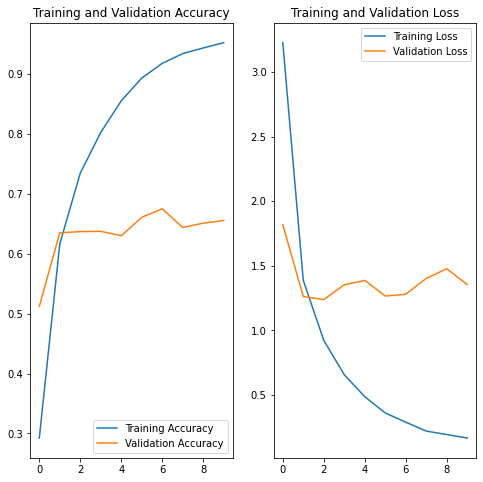

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
test_image = "/content/drive/MyDrive/Dog_Breed_Identification/briard.jpg"

img = keras.preprocessing.image.load_img(
    test_image, target_size=(size, size)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to briard with a 2.23 percent confidence.


In [ ]:
# This cell only saves the model to disk, don't run it if the model is good


#from keras.models import model_from_json
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("/content/drive/My Drive/Dog_Breed_Identification/v2modelresnet152_0604.h5")
#print("Saved model to disk")

#model.save("/content/drive/My Drive/Dog_Breed_Identification/v3modelresnet152_0604.h5")
#print("Saved whole model to disk")